## TODO: re-run with new results!

## Check observables given a results file from a `TRSL` simulation

We are checking:
1. Protein production rate
2. Ribosome speed
3. Ribosome density (TODO: compare with Siwiak)
4. Number of free ribosomes

In [1]:
import cPickle as pkl
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from statsmodels.nonparametric.smoothers_lowess import lowess

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [2]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

The following pickle file contains the simulation results:

In [6]:
filepath = "../results/20000 transcriptome, full exome, no decay, Plotkin initiation probabilities_20150921_1813_3599s.p"

Make file readable by `ipython` in case it was created by `pypy`:

In [7]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [8]:
results = pkl.load(open(filepath))

### 1. Protein production rate

In [9]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

Plot some randomly selected timecourses:

In [18]:
size = 5
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

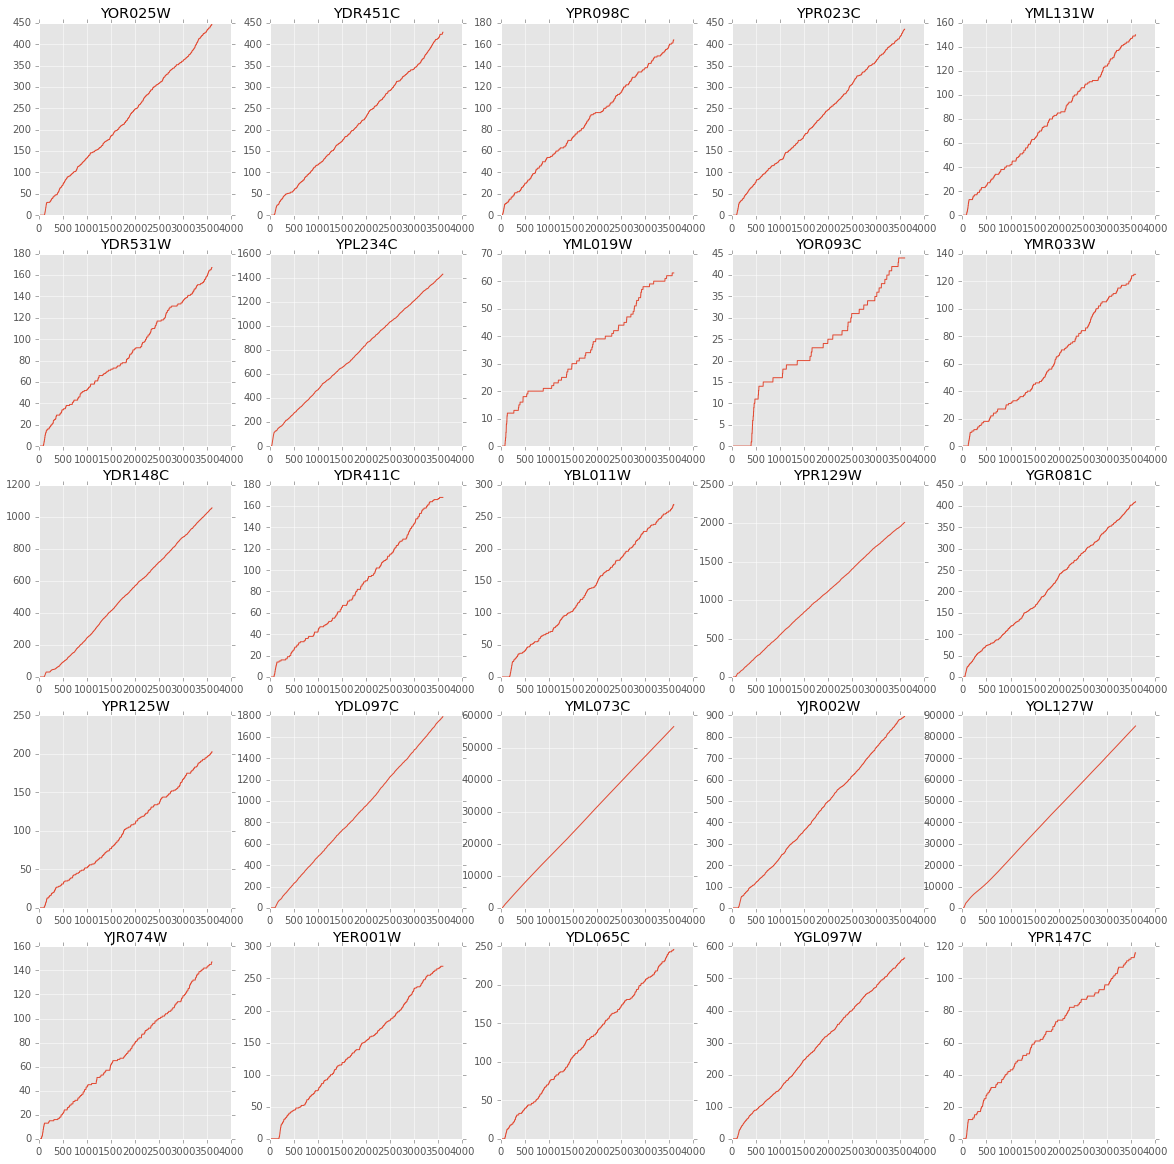

In [19]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        ax[i, j].plot(results['timerange'], results['timecourses'][protnames_plot[i][j]])
        ax[i, j].set_title(protnames_plot[i][j])

For each protein, calculate speed of translation (TODO: start and stop should be automatic):

In [20]:
start, stop = 599, 3599  # to exclude the "burn in" phase
prot_speeds = {}

for prot in protnames:
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * stop - start)
    if prot_speeds[prot] > 50: 
        print prot, prot_speeds[prot]

YKL060C 72.2756666667
YAL038W 73.0346666667
YCR012W 58.529
YOL086C 54.379
YLR044C 158.446333333


In [21]:
pd.Series(prot_speeds.values()).describe()

count    2415.000000
mean        1.092331
std         5.348256
min         0.006333
25%         0.046833
50%         0.121667
75%         0.384667
max       158.446333
dtype: float64

Distribution of translation speeds (finished protein molecules per second):

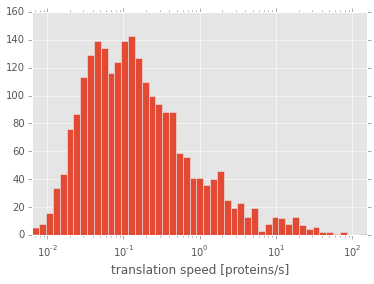

In [22]:
plt.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
plt.gca().set_xlabel('translation speed [proteins/s]')
plt.show()

In [23]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [24]:
peptide_speeds = {prot: prot_speeds[prot] * len(orf_genomic_dict[prot]) / 3.0 for prot in prot_speeds}

In [25]:
pd.Series(peptide_speeds.values()).describe()

count     2415.000000
mean       378.937436
std       2383.000307
min          1.755667
25%         17.706667
50%         44.904667
75%        140.410000
max      89363.732000
dtype: float64

Distribution of speeds of peptide bond creation (peptide bonds per second):

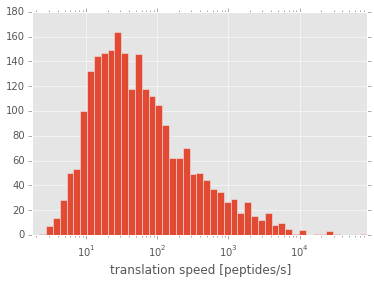

In [26]:
plt.hist(peptide_speeds.values(), bins = 10**np.linspace(np.log10(min(peptide_speeds.values())+0.0001), 
                                                              np.log10(max(peptide_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(peptide_speeds.values())+0.0001, max(peptide_speeds.values())])
plt.gca().set_xlabel('translation speed [peptides/s]')
plt.show()

Scatter plot speed, initiation rate and transcript abundance:

In [27]:
init_rates_plotkin = pkl.load(open('../parameters/init_rates_plotkin.p'))
print len(init_rates_plotkin)

2569


In [28]:
transcriptome_plotkin = pkl.load(open('../parameters/transcriptome_plotkin_20000.p'))
print len(transcriptome_plotkin)
print sum(transcriptome_plotkin.values())

4839
19969


In [29]:
df1 = pd.DataFrame.from_dict(peptide_speeds.items())
df1.columns = ['name', 'peptide_speeds']

df2 = pd.DataFrame.from_dict(init_rates_plotkin.items())
df2.columns = ['name', 'init_rates_plotkin']

df3 = pd.DataFrame.from_dict(transcriptome_plotkin.items())
df3.columns = ['name', 'transcriptome_plotkin_20000']

In [30]:
df = pd.merge(df1, df2, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df3, left_on='name', right_on='name', how='outer')

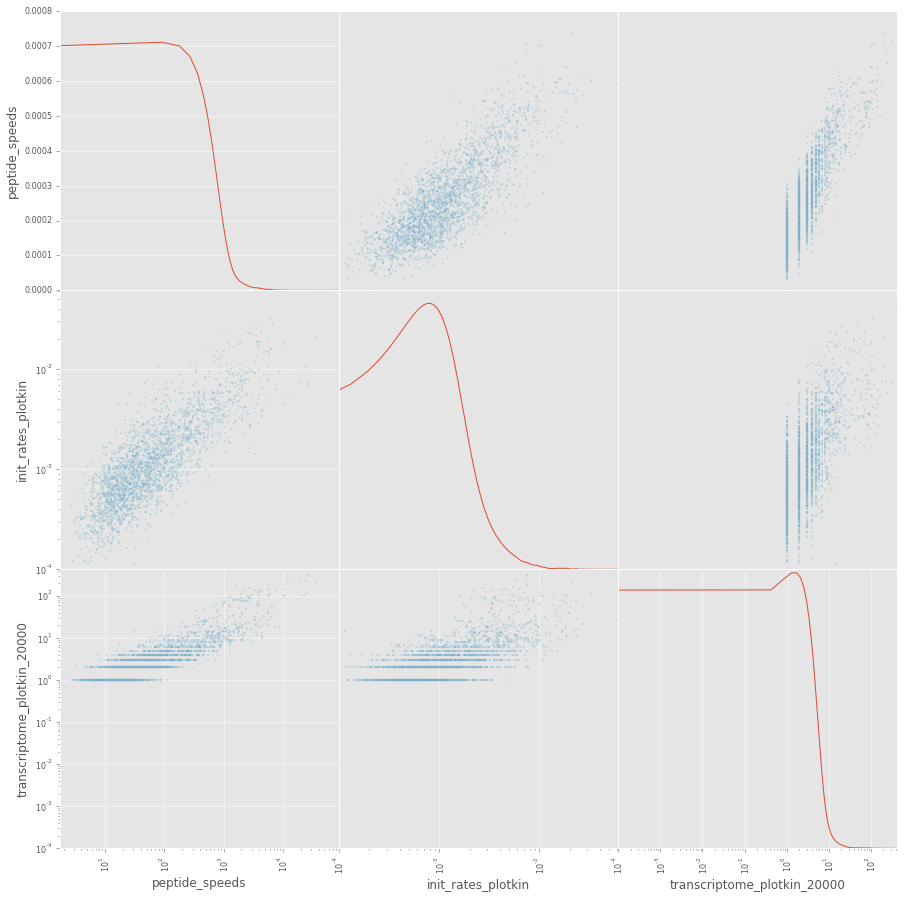

In [31]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')         

Best predictor of peptide translation speed appears to be initiation rate but also transcript abundance has some effect.

### 2. Ribosome speed

We read a results dictionary which contains tic/toc results for the mRNAs:

In [32]:
#filepath = "../results/20000 transcriptome, full exome, no decay, Plotkin initiation probabilities_20150825_1823_3599s.p"

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [33]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")
results = pkl.load(open(filepath))

The following is smaller than 20000 (or 19969 as in the original file), probably because not for every gene in `transcriptome_plotkin_20000.p` there is an initiation rate available.

In [34]:
len(results['transcriptome'])

16724

In [35]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [36]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

In [37]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [38]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [39]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [40]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [41]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic_toc']

In [42]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [43]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [44]:
pd.Series(orf_lengths.values()).describe()

count     5917.000000
mean      1485.306236
std       1149.149051
min         51.000000
25%        711.000000
50%       1218.000000
75%       1887.000000
max      14733.000000
dtype: float64

In [45]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'orf_length']

In [46]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

Scatter plot of ORF lengths against ribosome runtimes:

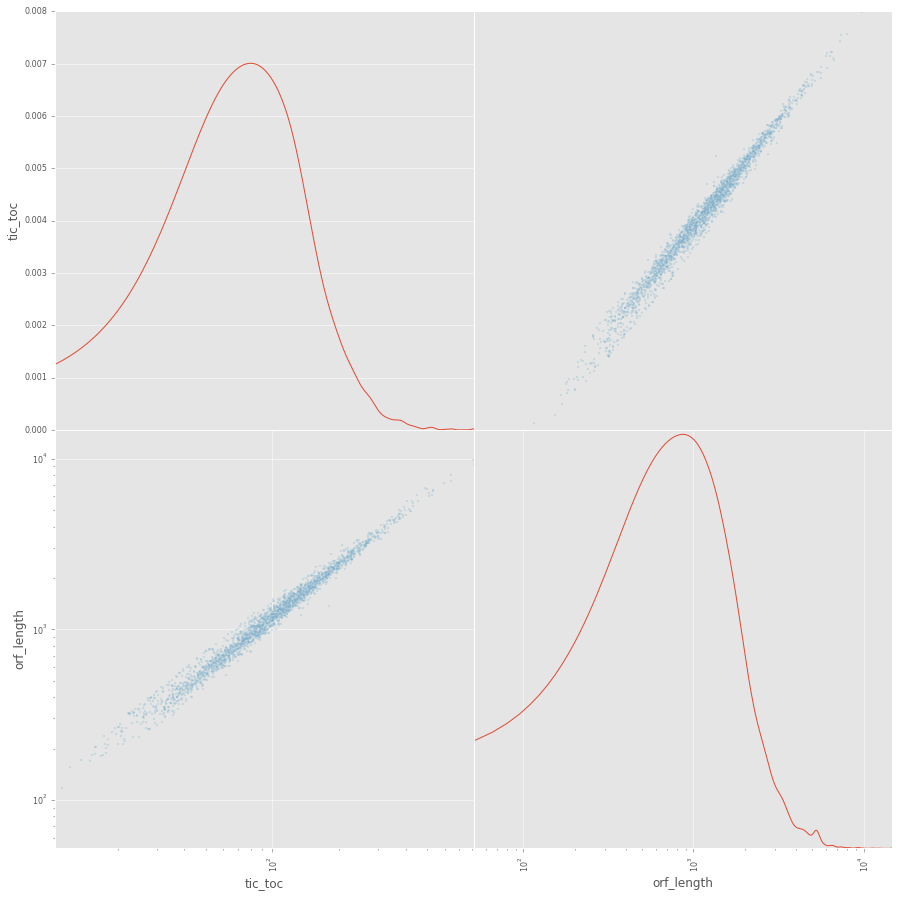

In [47]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj+1, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini+1, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')            

In [48]:
ribo_inverse_speed_dict = {geneID: gene_tic_toc[geneID]/orf_lengths[geneID] for geneID in gene_tic_toc}

In [49]:
pd.Series(ribo_inverse_speed_dict.values()).describe()

count    2415.000000
mean        0.084864
std         0.007226
min         0.065825
25%         0.080481
50%         0.084663
75%         0.088971
max         0.131826
dtype: float64

Distribution of inverse ribosome speeds (seconds per nucleotide):

(array([   5.,   11.,   12.,   20.,   19.,   22.,   27.,   39.,   34.,
          47.,   50.,   67.,   81.,  104.,  120.,  127.,  160.,  134.,
         143.,  155.,  161.,  134.,  125.,   88.,   85.,   79.,   61.,
          61.,   55.,   42.,   20.,   25.,   20.,   20.,   12.,    9.,
           5.,    4.,    7.,    4.,    5.,    5.,    4.,    1.,    2.,
           1.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([ 0.0658248,  0.0668248,  0.0678248,  0.0688248,  0.0698248,
         0.0708248,  0.0718248,  0.0728248,  0.0738248,  0.0748248,
         0.0758248,  0.0768248,  0.0778248,  0.0788248,  0.0798248,
         0.0808248,  0.0818248,  0.0828248,  0.0838248,  0.0848248,
         0.0858248,  0.0868248,  0.0878248,  0.0888248,  0.0898248,
         0.0908248,  0.0918248,  0.0928248,  0.0938248,  0.0948248,
         0.0958248,  0.0968248,  0.0978248,  0.0988248,  0.09982

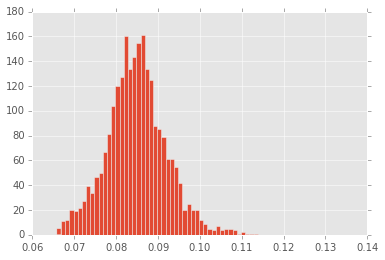

In [50]:
plt.hist(ribo_inverse_speed_dict.values(), bins=np.arange(min(ribo_inverse_speed_dict.values()), max(ribo_inverse_speed_dict.values()), 0.001))


In [51]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

Translation speed distribution (codons per second):

(array([   1.,    0.,    0.,    0.,    5.,   12.,   17.,   22.,   56.,
          97.,  155.,  207.,  274.,  344.,  289.,  292.,  210.,  137.,
          90.,   59.,   54.,   36.,   27.,   17.,   12.]),
 array([ 2.52858401,  2.62858401,  2.72858401,  2.82858401,  2.92858401,
         3.02858401,  3.12858401,  3.22858401,  3.32858401,  3.42858401,
         3.52858401,  3.62858401,  3.72858401,  3.82858401,  3.92858401,
         4.02858401,  4.12858401,  4.22858401,  4.32858401,  4.42858401,
         4.52858401,  4.62858401,  4.72858401,  4.82858401,  4.92858401,
         5.02858401]),
 <a list of 25 Patch objects>)

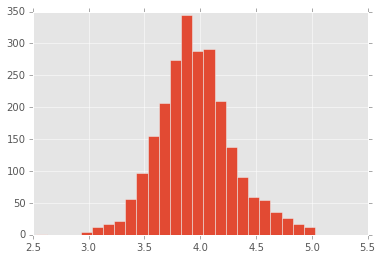

In [52]:
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.1))

TODO: Check against CAI

### 3. Ribosome density

Definition of ribosome density: average number of ribosomes per codon

Can depend on:

a) time - zero at first, reaches steady state (not discussed further)

b) position - density might be high at 5' end if initation rate is higher than rate at which ribosomes are transported away from initiation site

In [89]:
import shelve

filepath = "../results/ribosome_timecourses_20150921_1536.db"
d = shelve.open(filepath)

In [ ]:
resultsfile = "../results/20000 transcriptome, full exome, no decay, Plotkin initiation probabilities_20150921_1813_3599s.p"

In [90]:
replace(resultsfile, "_numpypy.multiarray", "numpy.core.multiarray")

In [ ]:
results = pkl.load(open(resultsfile))

Populate a dictionary with ribosome "lattices":

In [91]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

To make the ribosomes into a data frame, all array have to have the same length:

In [92]:
max_codons = len(max(ribo_lattice_dict.values(), key=len))

for gene in ribo_lattice_dict:
    ribo_lattice_dict[gene] = np.append(ribo_lattice_dict[gene], [None] * (max_codons - len(ribo_lattice_dict[gene])))

In [93]:
ribo_lattice_df = pd.DataFrame.from_dict(ribo_lattice_dict)
ribo_lattice_df

,YAL001C,YAL003W,YAL007C,YAL008W,YAL012W,YAL016W,YAL022C,YAL023C,YAL025C,YAL029C,YAL033W,YAL035W,YAL036C,YAL038W,YAL042W,YAL044C,YAL046C,YAL059W,YAL060W,YAR002W,
0,0,30,2,0,6,0,0,1,0,0,0,4,1,66,0,0,0,0,0,0,...
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,...
3,0,1,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,...
4,0,7,0,0,2,0,0,0,0,0,0,2,0,12,0,0,0,0,0,1,...
5,0,11,0,0,1,0,0,0,0,0,0,0,0,38,0,0,0,0,0,0,...
6,0,8,0,0,0,0,0,0,0,0,0,0,0,23,0,0,0,0,0,0,...
7,0,2,0,0,1,0,0,1,0,0,0,0,0,12,0,0,0,0,0,0,...
8,0,4,0,0,1,1,0,0,0,0,0,0,0,14,0,0,0,0,0,0,...
9,0,3,0,0,2,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,...


Check number of ribosomes in this data frame:

In [94]:
sum(dict(ribo_lattice_df.sum()).values())

199943.0

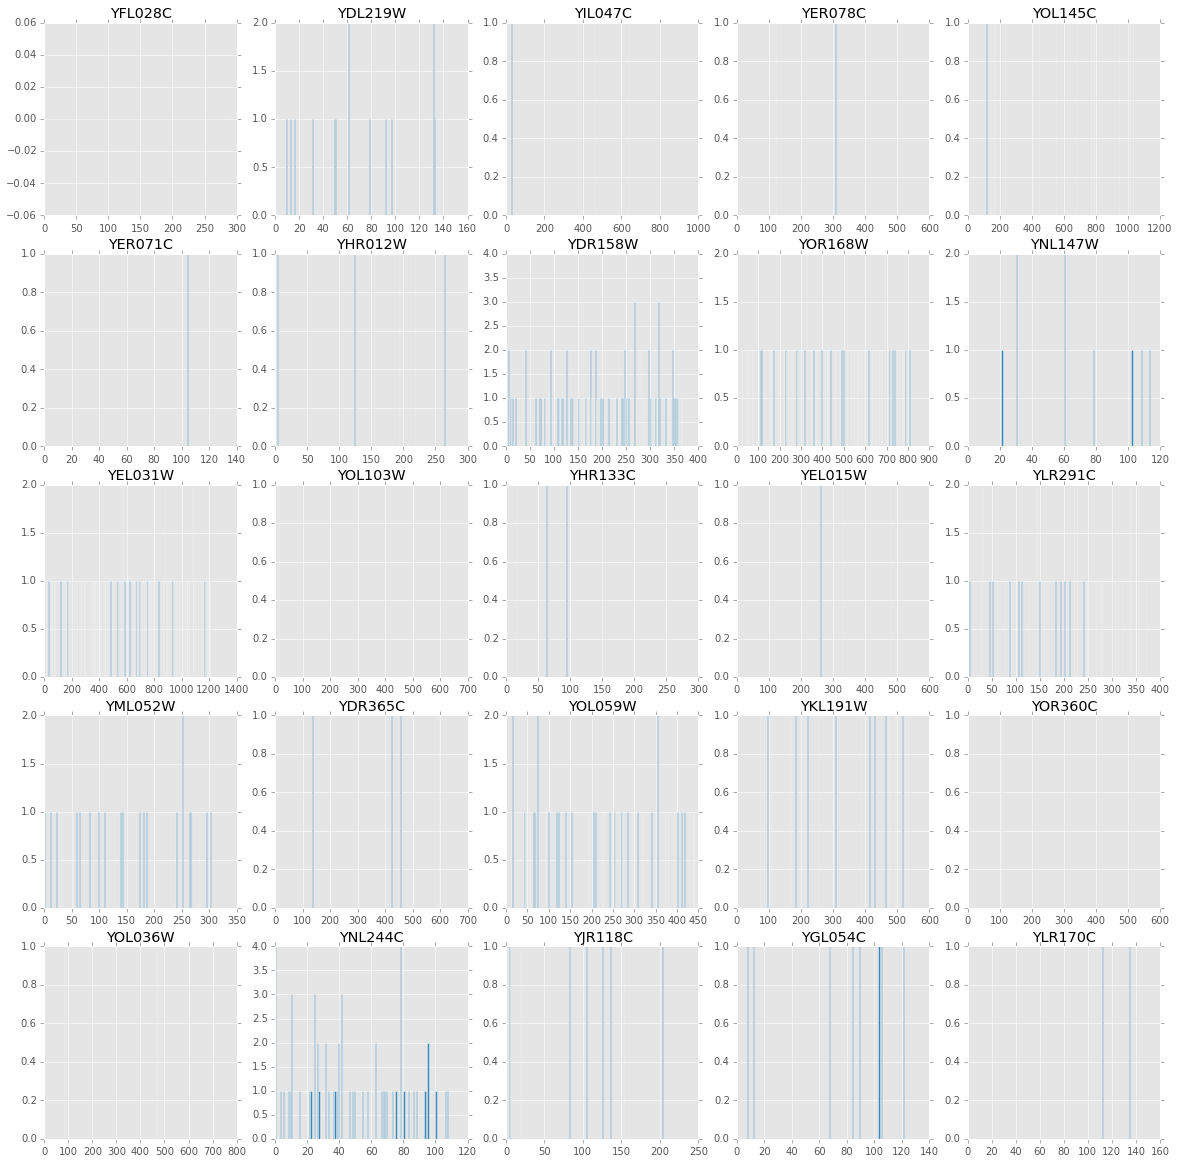

In [95]:
size = 5
genenames_plot = np.array(random.sample(ribo_lattice_dict.keys(), size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]] if elem is not None]
        ax[i, j].bar(range(len(plotlist)), plotlist)
        ax[i, j].set_title(genenames_plot[i][j])   


Average ribosome number per gene (average along the mRNA, across all codons):

In [96]:
average_ribos_per_gene = dict(ribo_lattice_df.mean(numeric_only=None))

Function to plot two dictionaries by their values:

In [97]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(0.2)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

Scatter plot against ORF lengths (mostly to rule out a mistake with the different lengths):

2381


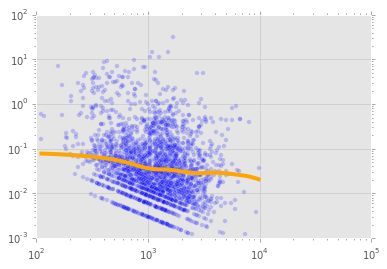

In [100]:
scatter_dicts(orf_lengths, {gene: average_ribos_per_gene[gene] for gene in average_ribos_per_gene 
                                if average_ribos_per_gene[gene] > 1e-16})

No recognizable correlation - probably correct!

This means dividing by the length takes care of the correlation.

Normalize by transcript abundance:

In [101]:
transcriptome = pkl.load(open("../parameters/transcriptome_plotkin_20000.p", "rb"))
init_rates = pkl.load(open("../parameters/init_rates_plotkin.p", "rb"))

In [102]:
print len(transcriptome)
print sum(transcriptome.values())

4839
19969


In [105]:
average_ribos_per_transcript = {gene: np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene]))                                
                                for gene in ribo_lattice_df
                                if np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene])) > 1e-16}

Plot against initiation rate:

2381


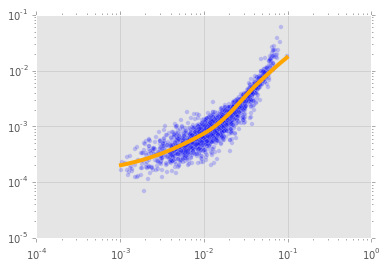

In [106]:
scatter_dicts(average_ribos_per_transcript, init_rates)

TODO: what explains the remaining dispersion? TODO: check CAI?

Analysis by codon position:

In [68]:
for column in ribo_lattice_df:
    ribo_lattice_df[column] = ribo_lattice_df[column]/float(transcriptome[column])

In [69]:
means_per_position = ribo_lattice_df.mean(axis=1, numeric_only=None)
means_per_position

0     0.068225
1     0.001780
2     0.004629
3     0.016329
4     0.023445
5     0.022211
6     0.015215
7     0.012923
8     0.016275
9     0.023598
10    0.016641
11    0.019083
12    0.016321
13    0.019811
14    0.017452
...
3254    0
3255    0
3256    0
3257    0
3258    0
3259    0
3260    0
3261    0
3262    0
3263    0
3264    0
3265    0
3266    0
3267    0
3268    0
Length: 3269, dtype: float64

In [70]:
positions = len(means_per_position)
# not all genes in the transcriptome have an orf_length, why?
transcripts_per_position = [sum([transcriptome[gene] for gene in transcriptome 
                            if gene in orf_lengths and position+1 <= orf_lengths[gene]/3])
                            for position in range(positions)]
len(transcripts_per_position)

3269

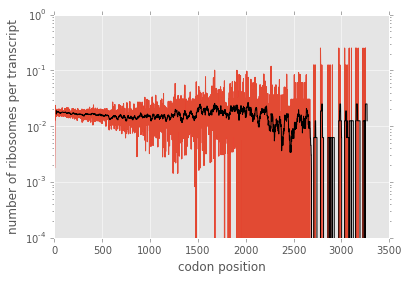

In [71]:
ts = means_per_position
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
plt.yscale('log') 
pd.rolling_mean(ts, 20).plot(style='k')

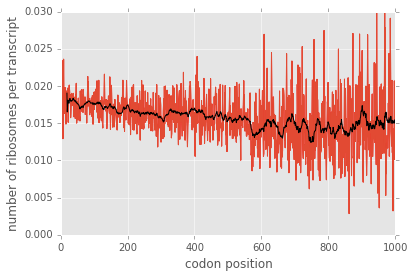

In [83]:
ts = means_per_position
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
plt.xlim([0, 1000])
plt.ylim([0, 0.03])
pd.rolling_mean(ts, 20).plot(style='k')

Is this a ribosome ramp?

Let us try on single genes:

Find gene with maximum transcription (for best statistics):

In [76]:
maxgene = max(transcriptome.iterkeys(), key=(lambda key: transcriptome[key]))
maxgene, transcriptome[maxgene]

('YLR044C', 428)

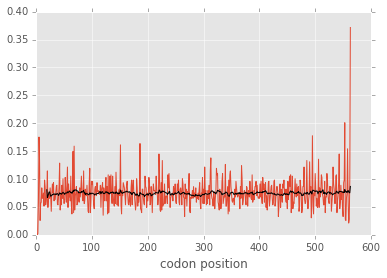

In [81]:
ribo_lattice_df[maxgene].plot().set_xlabel('codon position')
pd.rolling_mean(ribo_lattice_df[maxgene], 20).plot(style='k')

No ribosome ramp...

### 4. Number of free ribosomes

### 5. Distribution of mRNA count against ORF length

In [108]:
sum(transcriptome.values())

19969

4186


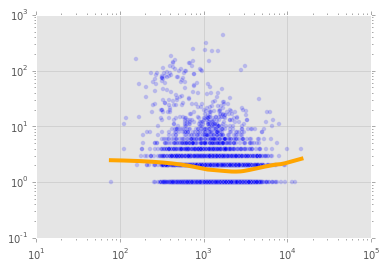

In [112]:
scatter_dicts(orf_lengths, {gene: transcriptome[gene] for gene in transcriptome if transcriptome[gene]>1e-16})

2496


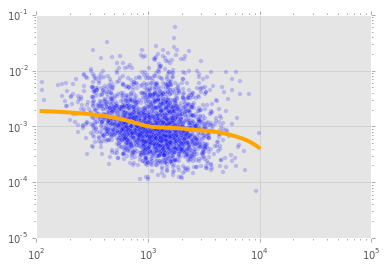

In [114]:
scatter_dicts(orf_lengths, init_rates_plotkin)

In [115]:
len(init_rates_plotkin)

2569

In [117]:
np.corrcoef(orf_lengths.values(), init_rates_plotkin.values())

TypeError: float() argument must be a string or a number